In [17]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
sys.path.append(os.path.join(os.getcwd(), '../'))

from symlie.misc.utils_results import get_and_check_Ps
from symlie.misc.wandb import update_results_df, get_inspect_df
from symlie.model.setup import load_P_pred
from symlie.model.networks.linear import LinearP
from symlie.model.networks.implicit import LinearImplicit
from symlie.misc.viz import plot2d

from symlie.run import parse_options, main, process_args

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
map_kwargses = {
    'full' : {'data_kwargs': {'grid_size': (1, 7), 'noise_std': 3}, 'transform_kwargs': {'eps_mult': [0.0, 0.0, 1.0, 0.0], 'only_flip': False}, 'data_dir': '../data/noise'}
}

svd_ranks = [3, 7, 14, 30]
for svd_rank in svd_ranks:

    map_kwargses[f'svd_rank{svd_rank}'] = map_kwargses['full'].copy()
    map_kwargses[f'svd_rank{svd_rank}']['svd_rank'] = svd_rank

seeds = [1]

In [3]:
Ps = {}

for svd, map_kwargs in map_kwargses.items():
    Ps[svd] = get_and_check_Ps(seeds, map_kwargs, use_P_from_noise = True)[0]

Found run_id xxidyaps
Found run_id ep9fxvi5
Found run_id twq70ezf
Found run_id n2s6xsu9
Found run_id 1glxxvmq


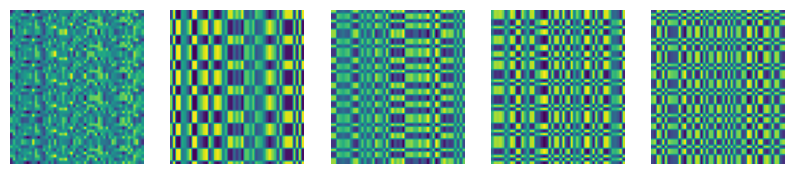

In [9]:
plot2d(list(Ps.values()), l = 2)

In [47]:
args = parse_options(notebook=True)

args.seed = 1
args.tags = ['dev']
args.batch_size = 16
args.max_epochs = 100

args.y_low = 1
args.y_high = 3
args.noise_std = 0.5
args.grid_size = (1, 7)
args.eps_mult = [0.0, 0.0, 1.0, 0.0]
args.data_dir = '../data/sine1d'
args.net = 'Predict-NoiseTrainedP'

args.n_train = 1000
args.lr = 0.001

args.svd_rank = 7
# args.logger = None

process_args(args)

# Training
model, trainer, datamodule = main(args)

Seed set to 1


Found run_id twq70ezf


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Running efficient-smoke-2370 with id f6op986u
Testing DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 894.29it/s]
(1000,) (1000,)
Logged regression results


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.16353142261505127    │
└───────────────────────────┴───────────────────────────┘

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [22]:
size = 7
x = torch.randn((1,size))
x.shape
x

tensor([[-0.5058, -2.7845, -1.1968,  0.0048, -0.4478,  0.3282,  0.2667]])

In [24]:
xprime = torch.roll(x, 1, 1)
xprime

tensor([[ 0.2667, -0.5058, -2.7845, -1.1968,  0.0048, -0.4478,  0.3282]])

In [33]:
layer_full = LinearP(in_features=size, out_features=size, bias=False, P_init=Ps['full'])
out_full = torch.stack([layer_full(x).detach(), layer_full(xprime).detach()]).squeeze()

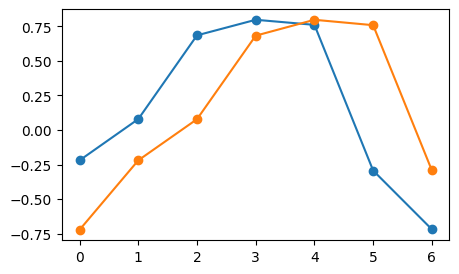

In [42]:
def plot_out(out):
    plt.figure(figsize=(5, 3))
    plt.plot(out.T, 'o-')
    plt.show()

plot_out(out_full)

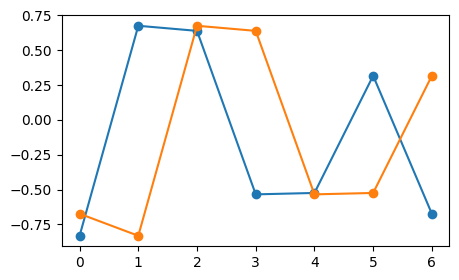

In [44]:
layer_svd = LinearP(in_features=size, out_features=size, bias=False, P_init=Ps['svd_rank7'])
out_svd = torch.stack([layer_svd(x).detach(), layer_svd(xprime).detach()]).squeeze()
plot_out(out_svd)